<a href="https://colab.research.google.com/github/engkailun3117/FYP_notebook/blob/main/MR_ENG_KAI_LUN_TP064276_CSDA_APD3F2308_SOLUTION_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount to Google Drive account to access data**

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  RobustScaler
from sklearn.neural_network import MLPRegressor
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error as mse, make_scorer
from sklearn import svm
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from keras import initializers, regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


!pip install category_encoders
from category_encoders import TargetEncoder, CountEncoder

# **Load data**

In [ ]:
path = '/drive/My Drive/Colab Notebooks/real_cd.csv'
data = pd.read_csv(path)

<ipython-input-3-5be3e071a360>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# **Self-defined Function:**

## **Validation metrics for single target variable**

In [ ]:
def validFun(prediction, y_test, acceptanceP):
  rmse = np.sqrt(mse(y_test,prediction))
  mape = mean_absolute_percentage_error(y_test, prediction)
  r2 = r2_score(y_test,prediction)

  print('MAPE: ', mape)
  print('RMSE: ', rmse)
  print('r2: ', r2)

  validNum = 0
  i = 0
  y_test_array = np.array(y_test)

  for x in prediction:
    validation = 1 - (prediction[i]/y_test_array[i])
    if((validation >= 0 and validation <= acceptanceP) or (validation >= -acceptanceP and validation <= 0)):
      validNum += 1
    i += 1

  modelSatisfyingValue = validNum/len(prediction) * 100
  print('Model Acceptance Percentage: ', modelSatisfyingValue)

## **Validation metrics for 4 target variable**

In [ ]:
def validFun4TV(prediction, y_test, acceptanceP):
    for i, target_var in enumerate(y_test.columns):
        rmse = np.sqrt(mse(y_test[target_var], prediction[:, i]))
        mape = mean_absolute_percentage_error(y_test[target_var], prediction[:, i])
        r2 = r2_score(y_test[target_var], prediction[:, i])

        print(f'Metrics for {target_var}:')
        print('MAPE:', mape)
        print('RMSE:', rmse)
        print('R^2:', r2)

        # Calculate the number of predictions satisfying the acceptance criteria
        validNum = 0
        for j in range(len(prediction)):
            validation = 1 - (prediction[j, i] / y_test.iloc[j, i])
            if ((validation >= 0 and validation <= acceptanceP) or (validation >= -acceptanceP and validation <= 0)):
                validNum += 1

        # Calculate the percentage of accepted predictions
        modelSatisfyingValue = validNum / len(prediction) * 100
        print('Model Acceptance Percentage:', modelSatisfyingValue)
        print('\n')

## **Result Plot for 4 target variables**

In [ ]:
def plot_result_multi(trainY, testY, train_predict, test_predict, target_vars):
    trainY_array = np.array(trainY)
    testY_array = np.array(testY)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        actual = np.append(trainY_array[:, i], testY_array[:, i])
        predictions = np.append(train_predict[:, i], test_predict[:, i])
        rows = len(actual)
        ax.plot(range(rows), actual)
        ax.plot(range(rows), predictions)
        ax.axvline(x=len(trainY), color='r')
        ax.legend(['Actual', 'Predictions'])
        ax.set_xlabel('Observation number after given time steps')
        ax.set_ylabel('Value')
        ax.set_title(f'Actual and Predicted Values for {target_vars[i]}')
    plt.tight_layout()

## **Custom Scoring Function (Model Accpetance Percentage) for Keras Model**

In [ ]:
# Define your custom scoring function
def custom_scoring_function(y_true, y_pred):

    ap_values = []

    for i, target_var in enumerate(y_true.columns):

        # Calculate the number of predictions satisfying the acceptance criteria
        validNum = 0
        for j in range(len(y_pred)):
            validation = 1 - (y_pred[j, i] / y_test.iloc[j, i])
            if ((validation >= 0 and validation <= 0.3) or (validation >= -0.3 and validation <= 0)):
                validNum += 1

        # Calculate the percentage of accepted predictions
        modelSatisfyingValue = validNum / len(y_pred) * 100
        ap_values.append(modelSatisfyingValue)

    avg_ap_values = np.mean(ap_values)

    return avg_ap_values

# **Features Selection (Correlation)**

<ipython-input-12-2717888cbce7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


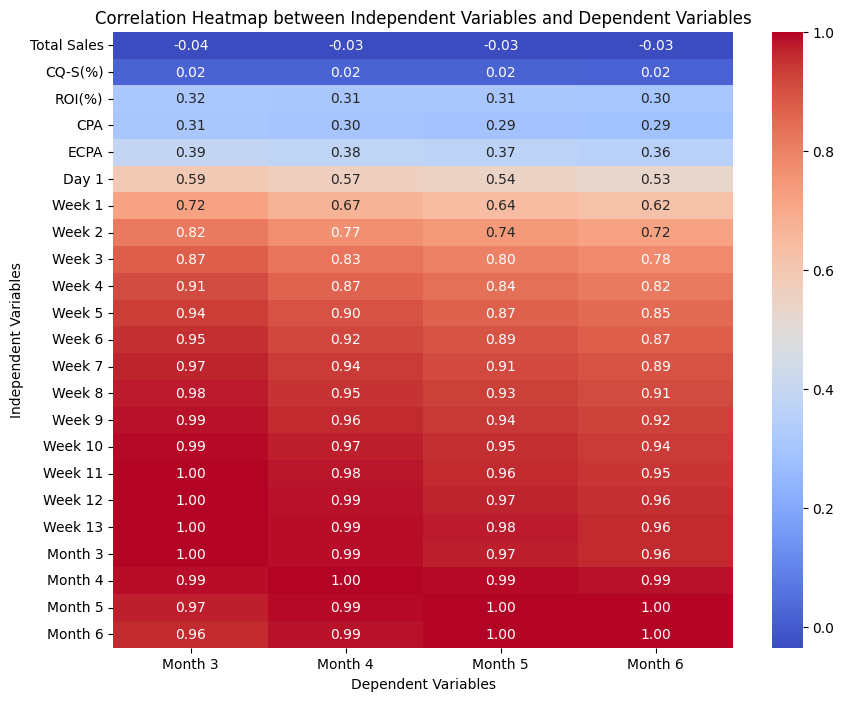

In [ ]:
# Compute correlation coefficients
correlation_matrix = data.corr()

# Extract correlations between independent variables and the dependent variables
correlation_with_target = correlation_matrix[['Month 3', 'Month 4', 'Month 5', 'Month 6']]

# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap between Independent Variables and Dependent Variables')
plt.xlabel('Dependent Variables')
plt.ylabel('Independent Variables')
plt.show()

This data is telecommunication service subscription data. The values in week and month refer to the accumulated revenue by that particulat time. The company wanted to predict the performances of its new subscription services that are newly published. After the discussion, the analyst and the company had agrrement to use week 1 revenue results to forecast month 3, 4, 5 and 6 results. Therefore, the attributes like week 2, 3, 4, 5 and so on are not used eventhough they are highly correlated.

# **Data Preprocessing**

In [ ]:
##------------------------------------------------------------- Data Preprocessing ----------------------------------------------------------------------------

# Change data type
data['ECPA'] = data['ECPA'].astype('float')
data['Keyword'] = data['Keyword'].astype('object')
data['Offer ID'] = data['Offer ID'].astype('object')
data['Affiliate ID'] = data['Affiliate ID'].astype('object')
data['Shortcode'] = data['Shortcode'].astype('object')

# Drop NA rows
filtered_empty = data.dropna(subset=['Offer ID', 'Affiliate ID', 'Shortcode', 'Total Sales', 'Day 1', 'Week 1'])

# Filter 0 values of the ARPU value
nonZero = filtered_empty [(filtered_empty ['Week 1'] > 0) & (filtered_empty ['Week 13'] > 0)].copy()

# Filter total sales
filtered_totalSales = nonZero [nonZero ['Total Sales'] >= 30].copy()

# Transform outliers
filtered_totalSales.loc[:,'Transform_TotalSales_log'] = np.log(filtered_totalSales['Total Sales'])
filtered_totalSales.loc[:,'Transform_ECPA'] = np.sqrt(filtered_totalSales['ECPA'])
filtered_totalSales.loc[:,'Transform_Day_1'] = np.sqrt(filtered_totalSales['Day 1'])
filtered_totalSales.loc[:,'Transform_Week_1'] = np.sqrt(filtered_totalSales['Week 1'])

# Transfrom date data type
filtered_totalSales['Date'] = pd.to_datetime(filtered_totalSales['Date'])

# Get current date time
current_date = datetime.now()

# Time slicing/filtering to get the completed records for machine learning
data_date = current_date - timedelta(days=93)
month3_data = filtered_totalSales[(filtered_totalSales['Date'] >= datetime(2022, 10, 1)) & (filtered_totalSales['Date'] <= data_date)]

# Define x and y
x = month3_data[['Country', 'Gateway','Telco', 'Shortcode', 'Keyword','Offer ID','Affiliate ID','Transform_TotalSales_log', 'Transform_ECPA', 'Transform_Day_1','Transform_Week_1']]
y = month3_data[['Month 3','Month 4','Month 5','Month 6']]

# Target_encoder encode label to transform categorical variables to numerical forms
count_encoder = CountEncoder()
x.loc[:,'Country'] = count_encoder.fit_transform(x['Country'])
x.loc[:,'Gateway'] = count_encoder.fit_transform(x['Gateway'])
x.loc[:,'Telco'] = count_encoder.fit_transform(x['Telco'])
x.loc[:,'Shortcode'] = count_encoder.fit_transform(x['Shortcode'])
x.loc[:,'Keyword'] = count_encoder.fit_transform(x['Keyword'])
x.loc[:,'Offer ID'] = count_encoder.fit_transform(x['Offer ID'])
x.loc[:,'Affiliate ID'] = count_encoder.fit_transform(x['Affiliate ID'])

# Data splitting
try:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=41)
except:
    print("\nError: Not enough data for building a training model for Month 3")
    print("You may adjust the filter setting to include more data (Note: This will affect the prediction result)\n")
    exit()

# Normalization
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# **Deep Neural Network (DNN) Model Building with Keras**

In [ ]:
L1 = 300
L2 = 200
L3 = 150
L4 = 100

model = Sequential()
model.add(Dense(L1, input_dim=x_train.shape[1], activation='relu'))  # Input layer with 128 neurons and ReLU activation
model.add(Dense(L2,activation='relu'))
model.add(Dense(L3,activation='relu'))
model.add(Dense(L4,activation='relu'))

# output layer
model.add(Dense(4))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')  # Using mean squared error as the loss function and Adam optimizer

# Early stoppage
early_stopping_monitor = EarlyStopping(patience=30)

history = model.fit(x_train, y_train, epochs=200, batch_size=30, validation_split=0.1, callbacks = [early_stopping_monitor])

Epoch 1/200
407/407 [==============================] - 4s 4ms/step - loss: 0.2604 - val_loss: 0.2070
Epoch 2/200
407/407 [==============================] - 2s 4ms/step - loss: 0.2240 - val_loss: 0.2041
Epoch 3/200
407/407 [==============================] - 2s 4ms/step - loss: 0.2140 - val_loss: 0.2167
Epoch 4/200
407/407 [==============================] - 2s 4ms/step - loss: 0.2052 - val_loss: 0.1859
Epoch 5/200
407/407 [==============================] - 2s 4ms/step - loss: 0.1970 - val_loss: 0.2018
Epoch 6/200
407/407 [==============================] - 2s 5ms/step - loss: 0.1946 - val_loss: 0.2005
Epoch 7/200
407/407 [==============================] - 3s 6ms/step - loss: 0.1887 - val_loss: 0.1853
Epoch 8/200
407/407 [==============================] - 2s 4ms/step - loss: 0.1897 - val_loss: 0.1917
Epoch 9/200
407/407 [==============================] - 2s 4ms/step - loss: 0.1834 - val_loss: 0.1729
Epoch 10/200
407/407 [==============================] - 2s 4ms/step - loss: 0.1780 - val_lo

## **Validation Results**

In [ ]:
DNNpredictions = model.predict(x_test)

validFun4TV(DNNpredictions, y_test, 0.3)

182/182 [==============================] - 0s 2ms/step
Metrics for Month 3:
MAPE: 0.36560492958375707
RMSE: 0.30711018251139727
R^2: 0.9205371662459981
Model Acceptance Percentage: 63.57056694813028


Metrics for Month 4:
MAPE: 0.3634796552201483
RMSE: 0.38537080229287374
R^2: 0.9040784631824685
Model Acceptance Percentage: 61.830087885576425


Metrics for Month 5:
MAPE: 0.3904997533848594
RMSE: 0.4393094586487914
R^2: 0.8946715253018422
Model Acceptance Percentage: 60.43425814234017


Metrics for Month 6:
MAPE: 0.3993562311348507
RMSE: 0.4905883033686072
R^2: 0.8831677123858858
Model Acceptance Percentage: 58.814406341547475




1. 'Model Acceptance Percentage' is a simple self-designed metric to measure the percentage of predicted results that met my expectation.

2. my expectation: prediction value & actual target value must not have 30% value differentiation

  Model Acceptance Percentage = 63% indicates that the analyst satisfied with the 63% of prediction results.

## **Plot Results**

421/421 [==============================] - 1s 2ms/step


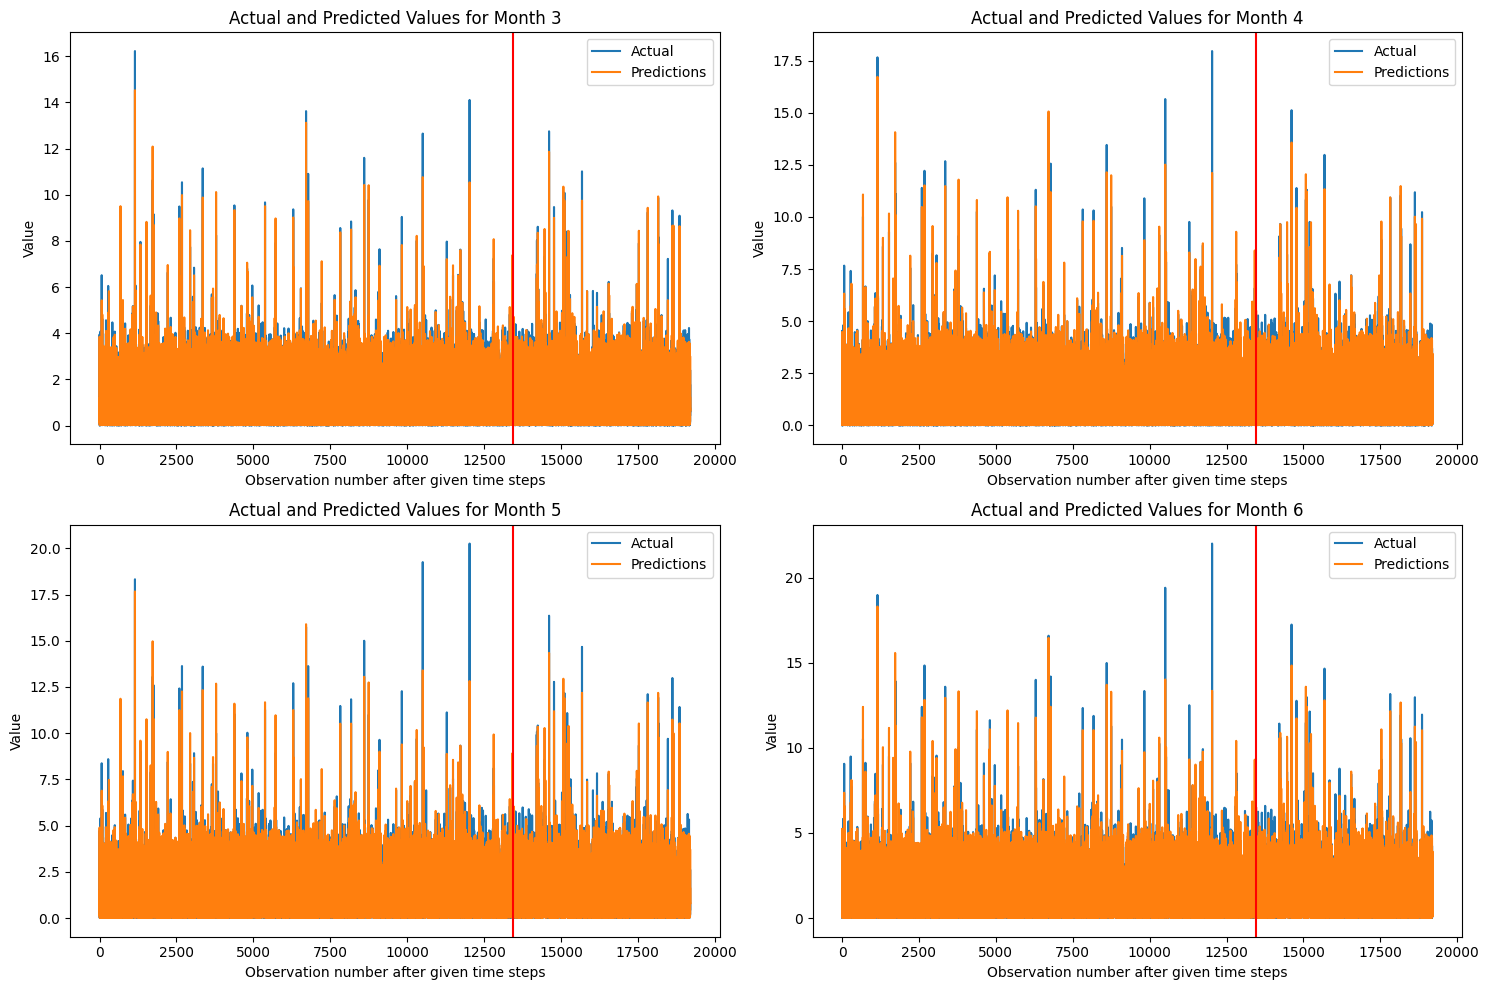

In [ ]:
# Plot differentiation graphs
train_predict = model.predict(x_train)

plot_result_multi(y_train, y_test, train_predict, DNNpredictions, y_test.columns)
plt.show()

# **Export prediction results to .csv file for observation and analyst**

In [ ]:
print_x = month3_data[['Month','Date','Country', 'Gateway','Telco', 'Shortcode','Keyword','Offer ID','Affiliate ID','Total Sales', 'ECPA', 'Day 1','Week 1']]
print_y = month3_data[['Month 3','Month 4', 'Month 5','Month 6']]

print_x_train, print_x_test, print_y_train, print_y_test = train_test_split(print_x, print_y, test_size=0.3, random_state=41)

resultData = {'Month':print_x_test['Month'],'Date':print_x_test['Date'],'Country':print_x_test['Country'], 'Gateway':print_x_test['Gateway'],'Telco':print_x_test['Telco'],
              'Shortcode':print_x_test['Shortcode'],'Keyword':print_x_test['Keyword'],'Offer ID':print_x_test['Offer ID'],'Affiliate ID':print_x_test['Affiliate ID'],'Total Sales':print_x_test['Total Sales'],
              'ECPA':print_x_test['ECPA'], 'Day 1':print_x_test['Day 1'],'Week 1':print_x_test['Week 1'], 'Month 3 (A)':print_y_test['Month 3'], 'Month 3 (P)':DNNpredictions[:,0],
              'Month 4 (A)':print_y_test['Month 4'], 'Month 4 (P)':DNNpredictions[:,1],
              'Month 5 (A)':print_y_test['Month 5'], 'Month 5 (P)':DNNpredictions[:,2],
              'Month 6 (A)':print_y_test['Month 6'], 'Month 6 (P)':DNNpredictions[:,3]}

result_df = pd.DataFrame(resultData)
result_df.to_csv('/drive/My Drive/Colab Notebooks/DNNresults.csv', index=False)

## The file looks like this (yellow highlights are columns added in csv file for analyst):

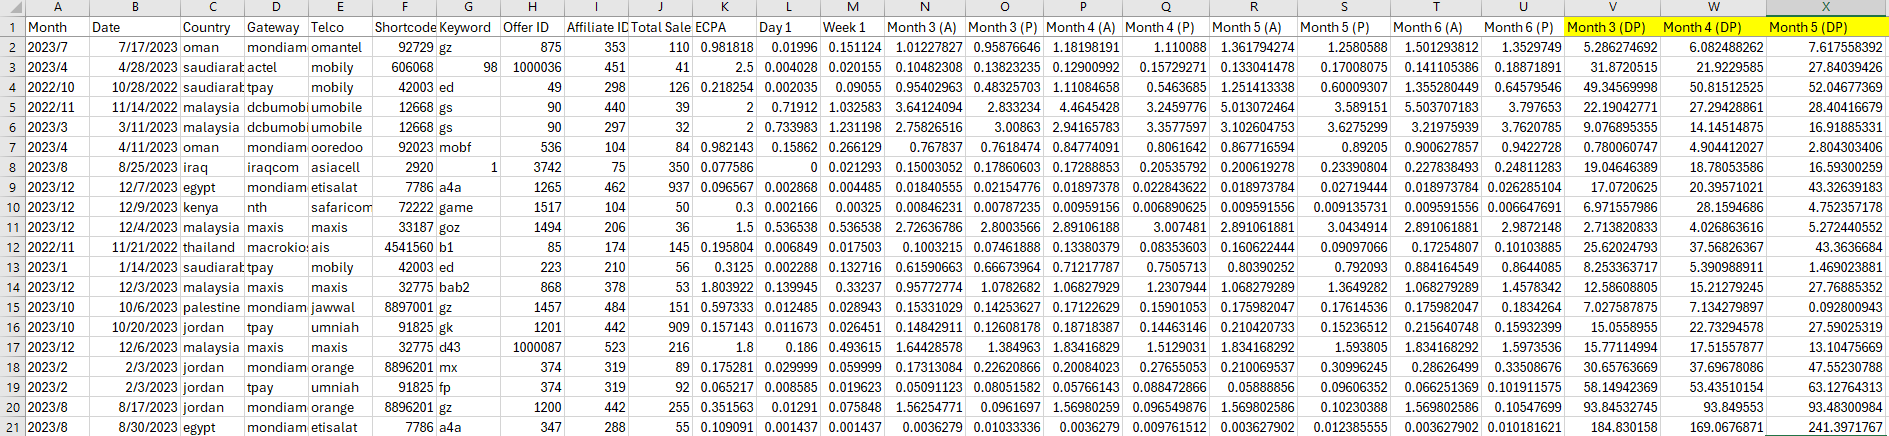

In [ ]:
from PIL import Image

img = Image.open('/drive/My Drive/Colab Notebooks/dnn csv file.png')
display(img)

yellow columns are the differentiation percentage between actual target value with the prediction value

**Result Findings:**
2 types of data mostly won't have accurate predictions:
1. **ARPU values that remain the same throughout weeks and months**
    
    **potential causes of the issues:** All the subscribes stop subscribing the service soon. The subscribers realise they might subscribe to the wrong service and immediatly cancel the subscriptions, but the records still kepts in the database
    
    **consequense:** The ARPU data remains the same since the begining until the timestamp that the analyze want to forecast, however, since that the ARPU is stationary and the forecast is not, the results are mostly wrong

2. **small ARPU value**

    The findings show that most of the unsatisfied predictions are those ARPU data with small decimal value, especially those service lines from Egypt. Those small decimal value data is outlier themselves


Screenshot of point 1: stationary ARPU values

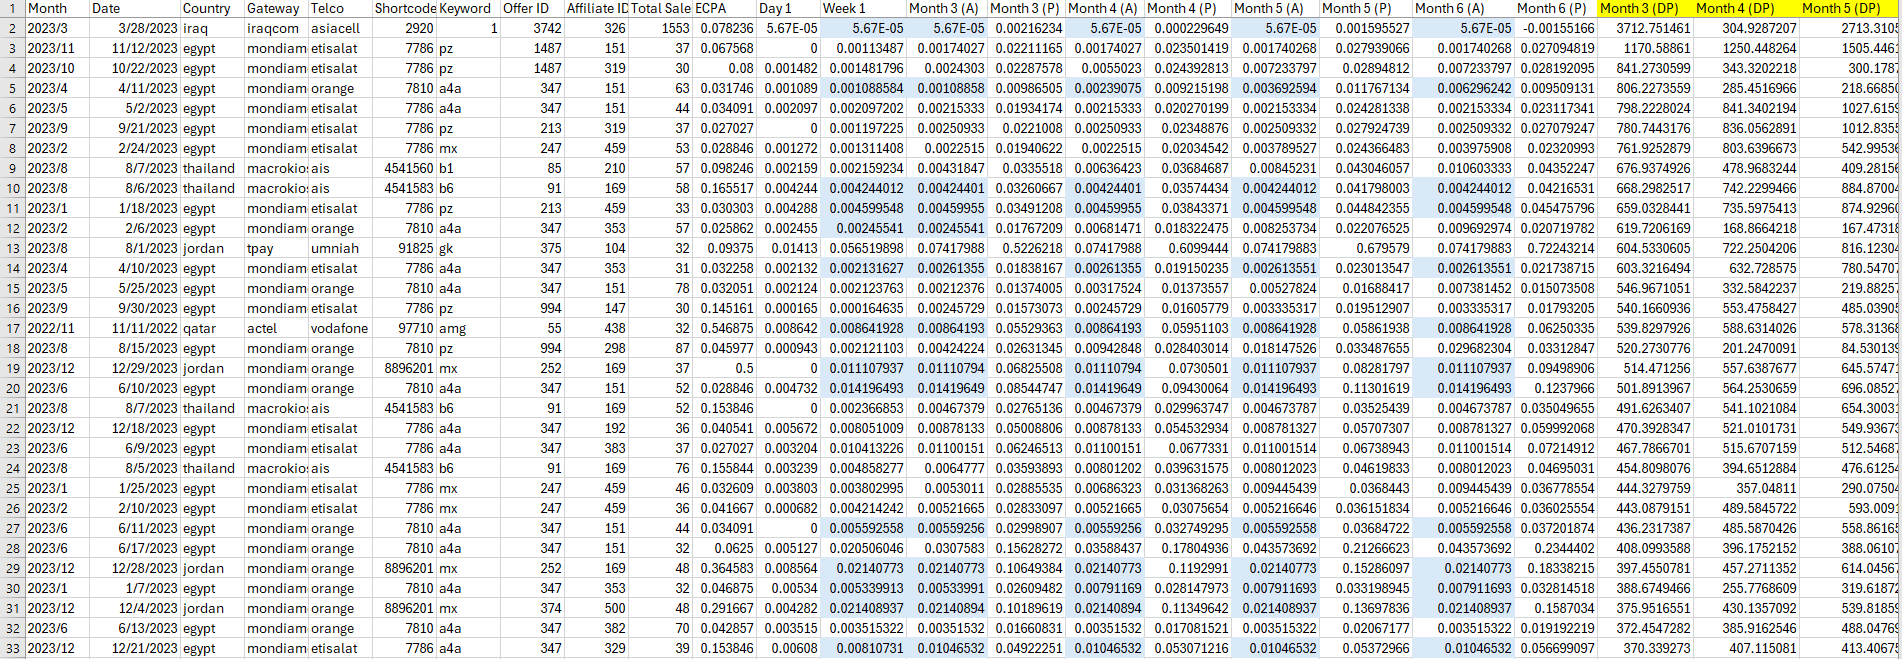

In [ ]:
img2 = Image.open('/drive/My Drive/Colab Notebooks/same value.png')
display(img2)

Screenshot of point 2: small ARPU value ('Week 1' mostly < 0.01)

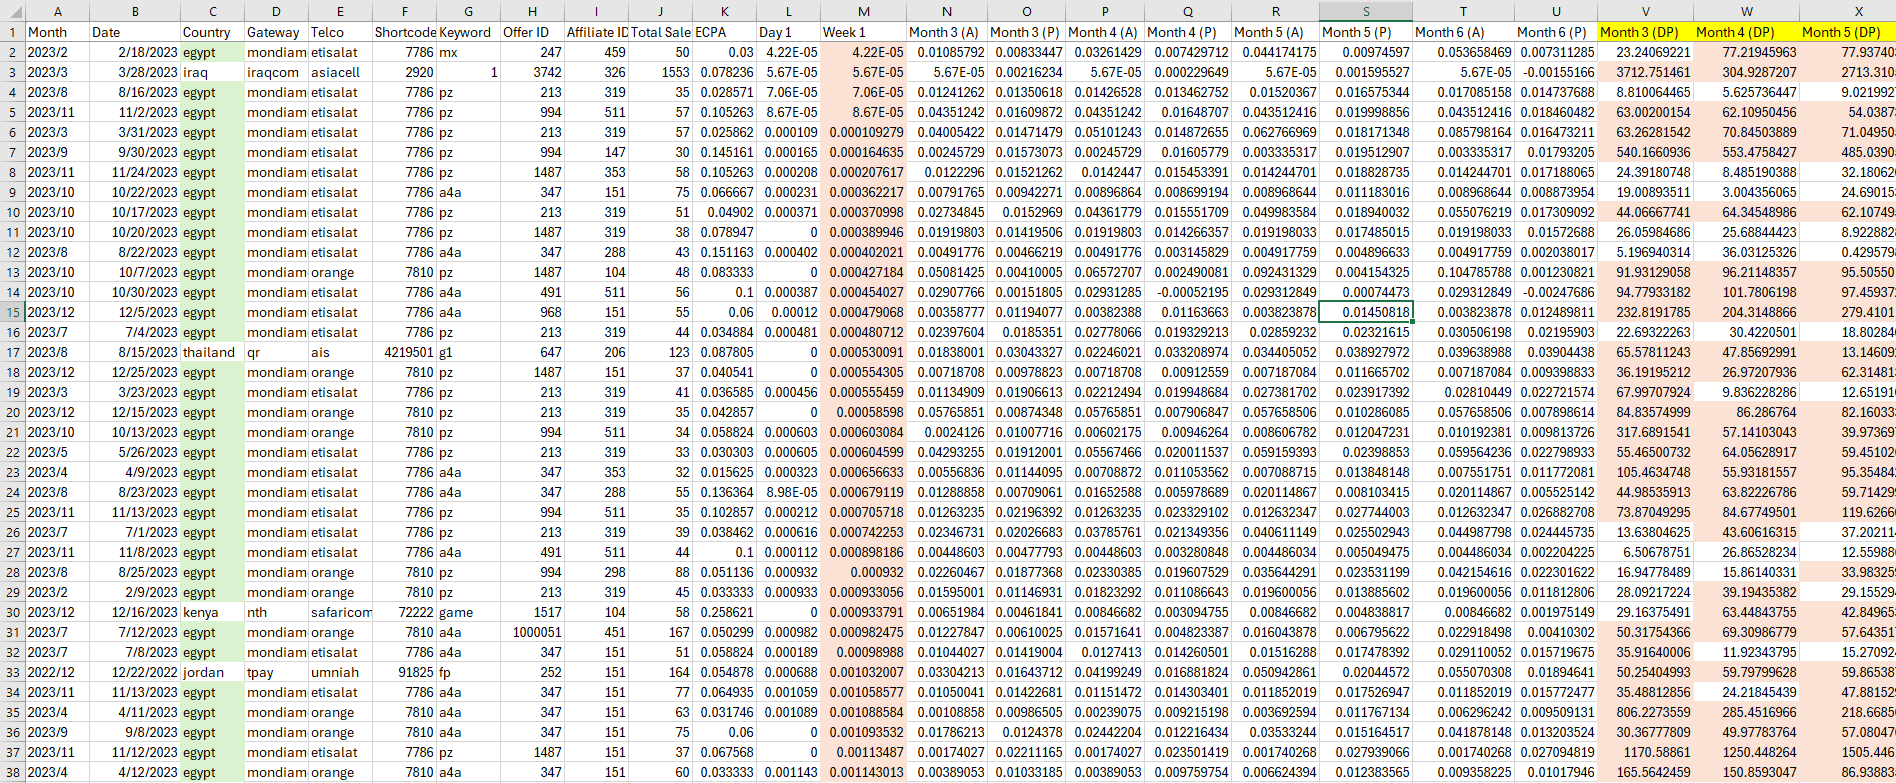

In [ ]:
img3 = Image.open('/drive/My Drive/Colab Notebooks/small value.png')
display(img3)

It is noticable that most of the unsatisfied results are small decimal values which means the model is not good at handling small values data. Most of the small value data is from Egypt country because of the currency problem. The values are too small compared with other records and they are the outliers which cannot be solved even after transforming the variable.




**Overall:**  *The analyst is not satisfy with this result and will try different approaches to get a better result in term of the satisfication on the model performance.*

# **Testing with Different Models**

## **Multi-layer Perceptron Regressor Neural Network (MLPRegressor) from scikit-learn**

In [ ]:
# MLP Regressor
mlpr = MLPRegressor(hidden_layer_sizes=(200, 150, 100, 50), activation='relu', solver='adam', learning_rate_init = 0.001 ,max_iter = 1000, random_state=42)
mlpr.fit(x_train, y_train)
MLPRprediction = mlpr.predict(x_test)

In [ ]:
validFun4TV(MLPRprediction, y_test, 0.3)

Metrics for Month 3:
MAPE: 0.5150331938998762
RMSE: 0.2689372936985485
R^2: 0.9390634760361337
Model Acceptance Percentage: 61.58883336205411


Metrics for Month 4:
MAPE: 0.7487661909020578
RMSE: 0.3364875498145656
R^2: 0.9268698417023827
Model Acceptance Percentage: 60.417025676374294


Metrics for Month 5:
MAPE: 0.9558555723084855
RMSE: 0.3943003758679726
R^2: 0.9151485889074032
Model Acceptance Percentage: 57.86662071342409


Metrics for Month 6:
MAPE: 0.9506393513605831
RMSE: 0.4418372454789972
R^2: 0.9052338697226083
Model Acceptance Percentage: 56.98776494916422




## **RBF Support Vector Regression (SVR) from scikit-learn**

In [ ]:
# Support Vector Regression (with Radial Basis Function)
from sklearn.multioutput import MultiOutputRegressor

base_model = svm.SVR()

SVR = MultiOutputRegressor(base_model)
SVR.fit(x_train, y_train)
SVRprediction = SVR.predict(x_test)

In [ ]:
validFun4TV(SVRprediction, y_test, 0.3)

Metrics for Month 3:
MAPE: 1.187758774908836
RMSE: 0.3358695607286524
R^2: 0.9049577062811467
Model Acceptance Percentage: 52.610718593830775


Metrics for Month 4:
MAPE: 1.1090697741307554
RMSE: 0.4290192510472135
R^2: 0.8811191026237024
Model Acceptance Percentage: 51.78356022746855


Metrics for Month 5:
MAPE: 1.0609810310838728
RMSE: 0.5076339793224829
R^2: 0.8593609072309374
Model Acceptance Percentage: 50.525590211959326


Metrics for Month 6:
MAPE: 1.104344409498684
RMSE: 0.5711970313494289
R^2: 0.8416199832216953
Model Acceptance Percentage: 49.595037049801824




## **Simple Regression**

In [ ]:
# Linear regression model
LR = LinearRegression()
LR.fit(x_train, y_train)
LRprediction = LR.predict(x_test)

In [ ]:
validFun4TV(LRprediction, y_test, 0.3)

Metrics for Month 3:
MAPE: 4.255512892294895
RMSE: 0.504584634022604
R^2: 0.7854919187430737
Model Acceptance Percentage: 29.364122005859038


Metrics for Month 4:
MAPE: 4.358834308669802
RMSE: 0.604683634805751
R^2: 0.7638353213939315
Model Acceptance Percentage: 29.24349474409788


Metrics for Month 5:
MAPE: 4.435293972661456
RMSE: 0.682454323684804
R^2: 0.7458138599836143
Model Acceptance Percentage: 29.691538859210752


Metrics for Month 6:
MAPE: 4.465401843839164
RMSE: 0.7408847140073348
R^2: 0.7335413824683767
Model Acceptance Percentage: 29.605376529381356




## **Huber Regression**

In [ ]:
from sklearn.linear_model import HuberRegressor

base_model = HuberRegressor(epsilon = 1.001) #the lower epsilon, the more robust it is to outliers

HR = MultiOutputRegressor(base_model)
HR.fit(x_train, y_train)
HRprediction = HR.predict(x_test)

In [ ]:
validFun4TV(HRprediction, y_test, 0.3)

Metrics for Month 3:
MAPE: 2.5916508906102487
RMSE: 0.5423767017675377
R^2: 0.7521564232891556
Model Acceptance Percentage: 35.18869550232638


Metrics for Month 4:
MAPE: 2.5875333059775416
RMSE: 0.6471670975082651
R^2: 0.7294849869939217
Model Acceptance Percentage: 34.25814234016888


Metrics for Month 5:
MAPE: 2.6473125457794535
RMSE: 0.7250367103236918
R^2: 0.7131038766463713
Model Acceptance Percentage: 33.70670342926073


Metrics for Month 6:
MAPE: 2.645753404418118
RMSE: 0.7863586838670511
R^2: 0.6998282096088602
Model Acceptance Percentage: 33.206961916250215




## **RANSAC Regression**

In [ ]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
ransac.fit(x_train, y_train)
RANSACprediction = ransac.predict(x_test)

In [ ]:
validFun4TV(RANSACprediction , y_test, 0.3)

Metrics for Month 3:
MAPE: 1.4114909869598686
RMSE: 0.8913557180005376
R^2: 0.33061230306978906
Model Acceptance Percentage: 28.364638979838013


Metrics for Month 4:
MAPE: 1.6647255296833092
RMSE: 1.0592767519795485
R^2: 0.2752680699940896
Model Acceptance Percentage: 26.12441840427365


Metrics for Month 5:
MAPE: 1.8597655051394701
RMSE: 1.1839966903867964
R^2: 0.2349220882828451
Model Acceptance Percentage: 24.573496467344476


Metrics for Month 6:
MAPE: 2.0016653933178987
RMSE: 1.2784194695631834
R^2: 0.20663095143080001
Model Acceptance Percentage: 23.660175771152854




# **Hyperparameter Tuning with Grid Search**

In [ ]:
!pip install scikeras

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

Due to my machine process power issue, complicated grid search combination will get no result after passing a certain time.

The solution is to apply grid search on a parameter to get the best setting and use that setting. The GridSearch will continue to be used on another paramter to get the best param and pass to another GridSearch run.

## **Batch size tunning**

In [ ]:
# Define the function to create the model
def create_model():
    # Create model
    model = Sequential()
    model.add(Dense(300, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(4))

    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')

    return model

# Wrap the Keras model in a scikit-learn regressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
batch_size = [10, 20, 30, 64, 100, 150, 225]

param_grid = dict(batch_size=batch_size)

# Define early stopping callback
early_stopping_monitor = EarlyStopping(patience=30)

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(x_train, y_train, epochs= 200,callbacks=[early_stopping_monitor])

# summarize results
print("Best negative rmse: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best negative rmse: -0.388929 using {'batch_size': 10}


## **Optimizer Tunning**

In [ ]:
def create_model():
    # Create model
    model = Sequential()
    model.add(Dense(300, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(4))

    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')

    return model

# Wrap the Keras model in a scikit-learn regressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)

# Define early stopping callback
early_stopping_monitor = EarlyStopping(patience=30)

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(x_train, y_train, epochs= 200, batch_size = 10, callbacks=[early_stopping_monitor])

# print results
print("Best negative rmse: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best negative rmse: -0.383101 using {'optimizer': 'Adadelta'}


## **Neuron Activation Function Tuning**

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(activation = 'relu'):
  # create model
  model = Sequential()
  model.add(Dense(300, input_dim=x_train.shape[1], activation=activation))
  model.add(Dense(200, activation=activation))
  model.add(Dense(150, activation=activation))
  model.add(Dense(100, activation=activation))
  model.add(Dense(4))

  # Compile model
  model.compile(loss='mean_absolute_error', optimizer='adadelta')
  return model

model2 = KerasRegressor(build_fn=create_model, verbose=0)
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
early_stopping_monitor = EarlyStopping(patience=30)
grid = GridSearchCV(estimator=model2, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, epochs= 200, batch_size = 10, callbacks=[early_stopping_monitor])
print("Best negative rmse: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best negative rmse: -0.550407 using {'model__activation': 'relu'}


## **Neurons Tuning**

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons):
  # create model
  model = Sequential()
  model.add(Dense(neurons, input_dim = x_train.shape[1], activation='relu'))
  model.add(Dense(neurons, activation = 'relu'))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(4))

  # Compile model
  model.compile(loss='mean_absolute_error', optimizer='adadelta')
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)
neurons = [15, 25, 50, 75, 90, 150, 200, 300]
param_grid = dict(model__neurons=neurons)
early_stopping_monitor = EarlyStopping(patience=30)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, epochs= 200, batch_size = 10, callbacks=[early_stopping_monitor])
print("Best negative rmse: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Best negative rmse: -0.549716 using {'model__neurons': 300}


## **Following the Hypertunning Parameters from GridSearch**

In [ ]:
model = Sequential()
model.add(Dense(300, input_dim=x_train.shape[1], activation='relu'))  # Input layer with 128 neurons and ReLU activation
model.add(Dense(300,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))

# output layer (softmax = multinomial)
model.add(Dense(4))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adadelta')  # Using mean squared error as the loss function and Adam optimizer

# Early stoppage
early_stopping_monitor = EarlyStopping(patience=30)

# Assign high epoch for adadelta
history = model.fit(x_train, y_train, epochs=2000, batch_size=10, validation_split=0.1, callbacks = [early_stopping_monitor])

Epoch 1/2000
1229/1229 [==============================] - 9s 7ms/step - loss: 0.7801 - val_loss: 0.7156
Epoch 2/2000
1229/1229 [==============================] - 6s 5ms/step - loss: 0.7225 - val_loss: 0.6584
Epoch 3/2000
1229/1229 [==============================] - 8s 6ms/step - loss: 0.6664 - val_loss: 0.6023
Epoch 4/2000
1229/1229 [==============================] - 6s 5ms/step - loss: 0.6119 - val_loss: 0.5488
Epoch 5/2000
1229/1229 [==============================] - 8s 6ms/step - loss: 0.5593 - val_loss: 0.4983
Epoch 6/2000
1229/1229 [==============================] - 6s 5ms/step - loss: 0.5103 - val_loss: 0.4532
Epoch 7/2000
1229/1229 [==============================] - 8s 6ms/step - loss: 0.4666 - val_loss: 0.4142
Epoch 8/2000
1229/1229 [==============================] - 6s 5ms/step - loss: 0.4295 - val_loss: 0.3819
Epoch 9/2000
1229/1229 [==============================] - 9s 7ms/step - loss: 0.3990 - val_loss: 0.3547
Epoch 10/2000
1229/1229 [==============================] - 6s 5m

**Show the performance**

In [ ]:
DNNpredictions = model.predict(x_test)

validFun4TV(DNNpredictions, y_test, 0.3)

183/183 [==============================] - 1s 2ms/step
Metrics for Month 3:
MAPE: 0.4560910751261106
RMSE: 0.31496149372794874
R^2: 0.9127365484678509
Model Acceptance Percentage: 62.450863100324725


Metrics for Month 4:
MAPE: 0.3991616270896461
RMSE: 0.3954934496160407
R^2: 0.8935791859278152
Model Acceptance Percentage: 60.53666039993164


Metrics for Month 5:
MAPE: 0.42417530833076533
RMSE: 0.45888258778013136
R^2: 0.8784339421942812
Model Acceptance Percentage: 59.57955904973509


Metrics for Month 6:
MAPE: 0.4636798251161511
RMSE: 0.5081180723771573
R^2: 0.8666397264047394
Model Acceptance Percentage: 58.0242693556657




**Plot the loss graph**

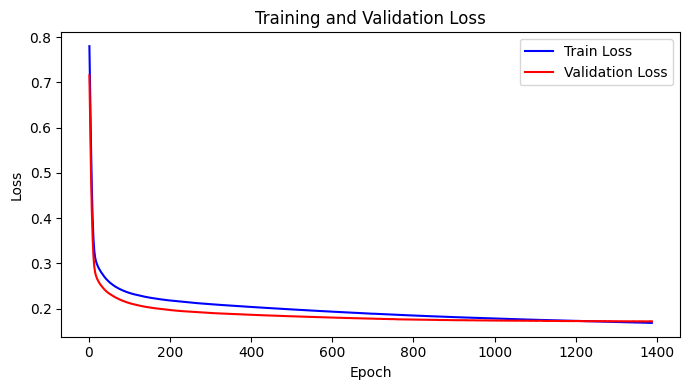

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

plt.plot(epochs, loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()



427/427 [==============================] - 1s 2ms/step


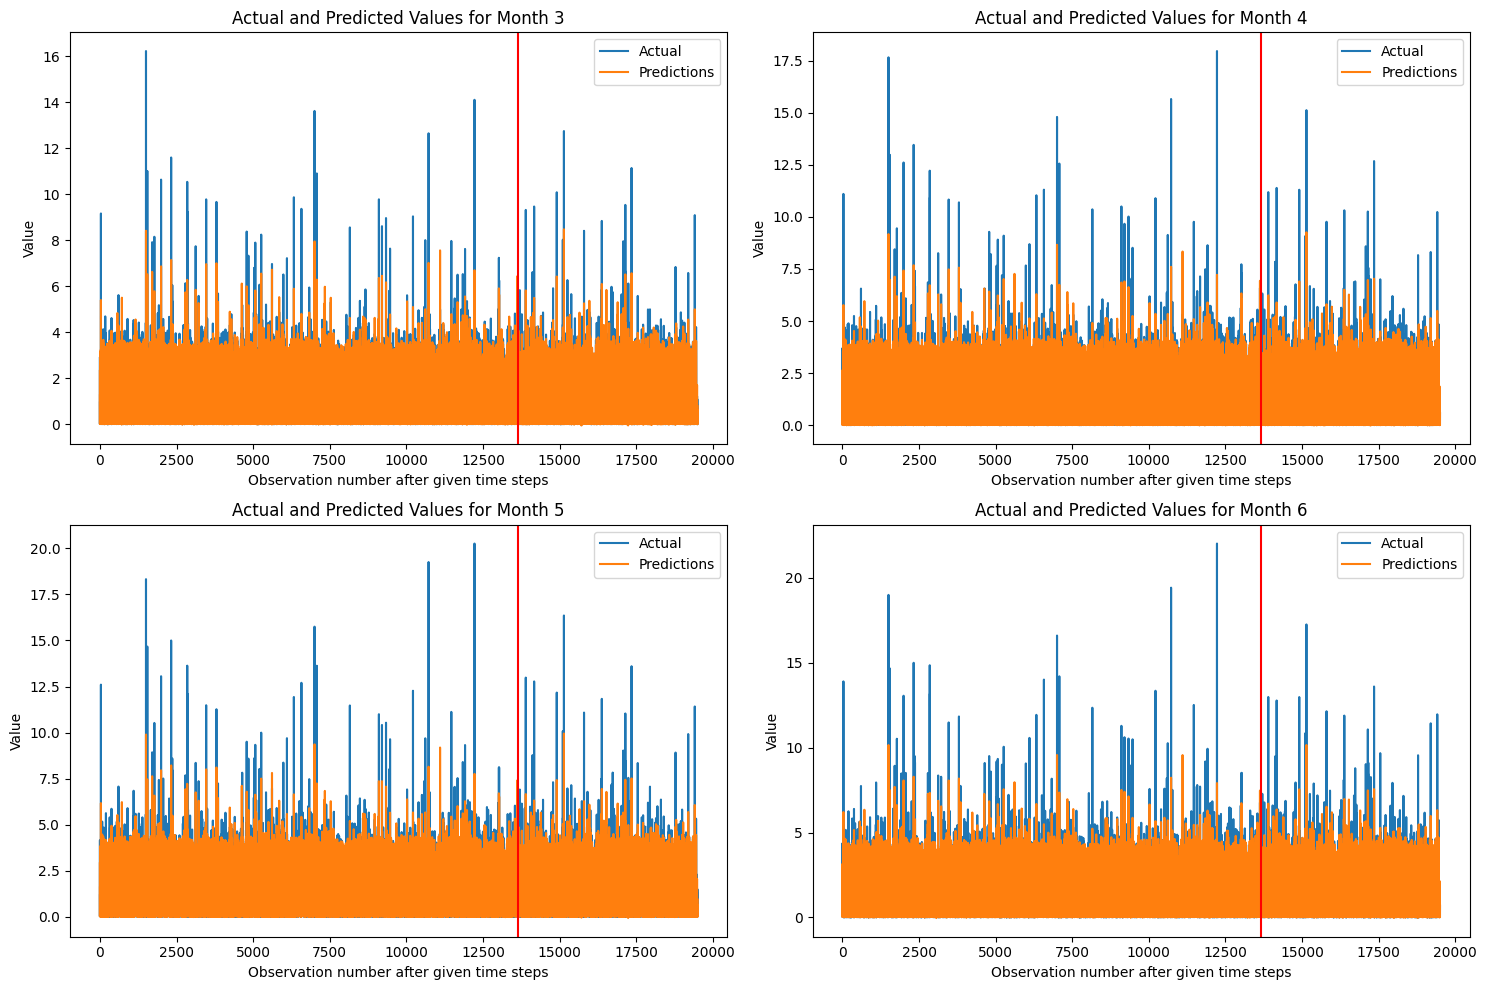

In [ ]:
# Plot differentiation graphs
train_predict = model.predict(x_train)

plot_result_multi(y_train, y_test, train_predict, DNNpredictions, y_test.columns)
plt.show()

## **Save the DNN GridSearch model**

In [ ]:
model.save('/drive/My Drive/Colab Notebooks/DNNGridSearch.keras')

## **Summary**

The hypertuned model is not performing better than the previous model especially the differences between actual target values and prediction values. Other methods should be investigated to improve the prediction results. For future work: instead of forecasting the future ARPU values, the data analyst may conduct customer churn prediction too because the revenue is based on the existing customers on the service line. Once all the subscribers stop subscribing, the revenue stops growing. For this statistical model, the machine is unable to capture the information of when a subscriber stop subscribing the service, this explains the observation results above.

# **Two Approaches for Improving the Performances**

## **1. Adding Revenue Features such as 'Week 2' & 'Week 3'**

**Pros:**

.the model's accuracy will have significant improvement

.subscribers that unsubscribe the operators early will be detected


**Cons:**

.unable to satisfy the company's initial plan to use the first week performance data to forecast later date performance

.unable to make immediate response. This requires 'n' weeks to collect the week 'n' data for the new business records

In [ ]:
##------------------------------------------------------------- Data Preprocessing ----------------------------------------------------------------------------

# Change data type
data['ECPA'] = data['ECPA'].astype('float')
data['Keyword'] = data['Keyword'].astype('object')
data['Offer ID'] = data['Offer ID'].astype('object')
data['Affiliate ID'] = data['Affiliate ID'].astype('object')
data['Shortcode'] = data['Shortcode'].astype('object')

# Drop NA rows
filtered_empty = data.dropna(subset=['Offer ID', 'Affiliate ID', 'Shortcode', 'Total Sales', 'Day 1', 'Week 1'])

# Filter 0 values of the ARPU value
nonZero = filtered_empty [(filtered_empty ['Week 1'] > 0) & (filtered_empty ['Week 13'] > 0)].copy()

# Filter total sales
filtered_totalSales = nonZero [nonZero ['Total Sales'] >= 30].copy()

# Transform outliers
filtered_totalSales.loc[:,'Transform_TotalSales_log'] = np.log(filtered_totalSales['Total Sales'])
filtered_totalSales.loc[:,'Transform_ECPA'] = np.sqrt(filtered_totalSales['ECPA'])
filtered_totalSales.loc[:,'Transform_Day_1'] = np.sqrt(filtered_totalSales['Day 1'])
filtered_totalSales.loc[:,'Transform_Week_1'] = np.sqrt(filtered_totalSales['Week 1'])
filtered_totalSales.loc[:,'Transform_Week_2'] = np.sqrt(filtered_totalSales['Week 2'])
filtered_totalSales.loc[:,'Transform_Week_3'] = np.sqrt(filtered_totalSales['Week 3'])

# Transfrom date data type
filtered_totalSales['Date'] = pd.to_datetime(filtered_totalSales['Date'])

# Get current date time
current_date = datetime.now()

# Time slicing/filtering to get the completed records for machine learning
data_date = current_date - timedelta(days=93)
month3_data = filtered_totalSales[(filtered_totalSales['Date'] >= datetime(2022, 10, 1)) & (filtered_totalSales['Date'] <= data_date)]

# Define x and y
x = month3_data[['Country', 'Gateway','Telco', 'Shortcode', 'Keyword','Offer ID','Affiliate ID','Transform_TotalSales_log', 'Transform_ECPA',
                 'Transform_Day_1','Transform_Week_1','Transform_Week_2','Transform_Week_3']]
y = month3_data[['Month 3','Month 4','Month 5','Month 6']]

# Target_encoder encode label to transform categorical variables to numerical forms
count_encoder = CountEncoder()
x.loc[:,'Country'] = count_encoder.fit_transform(x['Country'])
x.loc[:,'Gateway'] = count_encoder.fit_transform(x['Gateway'])
x.loc[:,'Telco'] = count_encoder.fit_transform(x['Telco'])
x.loc[:,'Shortcode'] = count_encoder.fit_transform(x['Shortcode'])
x.loc[:,'Keyword'] = count_encoder.fit_transform(x['Keyword'])
x.loc[:,'Offer ID'] = count_encoder.fit_transform(x['Offer ID'])
x.loc[:,'Affiliate ID'] = count_encoder.fit_transform(x['Affiliate ID'])

# Data splitting
try:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=41)
except:
    print("\nError: Not enough data for building a training model for Month 3")
    print("You may adjust the filter setting to include more data (Note: This will affect the prediction result)\n")
    exit()

# Normalization
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
L1 = 300
L2 = 200
L3 = 150
L4 = 100

model = Sequential()
model.add(Dense(L1, input_dim=x_train.shape[1], activation='relu'))  # Input layer with 128 neurons and ReLU activation
model.add(Dense(L2,activation='relu'))
model.add(Dense(L3,activation='relu'))
model.add(Dense(L4,activation='relu'))

# output layer
model.add(Dense(4))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')  # Using mean squared error as the loss function and Adam optimizer

# Early stoppage
early_stopping_monitor = EarlyStopping(patience=30)

history = model.fit(x_train, y_train, epochs=200, batch_size=30, validation_split=0.1, callbacks = [early_stopping_monitor])

Epoch 1/200
410/410 [==============================] - 5s 5ms/step - loss: 0.2101 - val_loss: 0.1781
Epoch 2/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1775 - val_loss: 0.1458
Epoch 3/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1635 - val_loss: 0.1491
Epoch 4/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1566 - val_loss: 0.1530
Epoch 5/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1562 - val_loss: 0.1375
Epoch 6/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1505 - val_loss: 0.1382
Epoch 7/200
410/410 [==============================] - 2s 6ms/step - loss: 0.1520 - val_loss: 0.1473
Epoch 8/200
410/410 [==============================] - 2s 5ms/step - loss: 0.1465 - val_loss: 0.1330
Epoch 9/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1492 - val_loss: 0.1329
Epoch 10/200
410/410 [==============================] - 2s 4ms/step - loss: 0.1443 - val_lo

In [ ]:
DNNpredictions = model.predict(x_test)

validFun4TV(DNNpredictions, y_test, 0.3)

183/183 [==============================] - 1s 7ms/step
Metrics for Month 3:
MAPE: 0.2438418985769493
RMSE: 0.1863775219685217
R^2: 0.9694434351141664
Model Acceptance Percentage: 73.54298410528115


Metrics for Month 4:
MAPE: 0.26869826152744036
RMSE: 0.2512010403126267
R^2: 0.9570670377765805
Model Acceptance Percentage: 70.07349171081866


Metrics for Month 5:
MAPE: 0.3044074029928508
RMSE: 0.30580437993039905
R^2: 0.9460120821185088
Model Acceptance Percentage: 66.87745684498377


Metrics for Month 6:
MAPE: 0.3176240090838655
RMSE: 0.34896242896134166
R^2: 0.9370994364594513
Model Acceptance Percentage: 65.32216715091438




All performances are far better than previous models

**Results:**

427/427 [==============================] - 1s 2ms/step


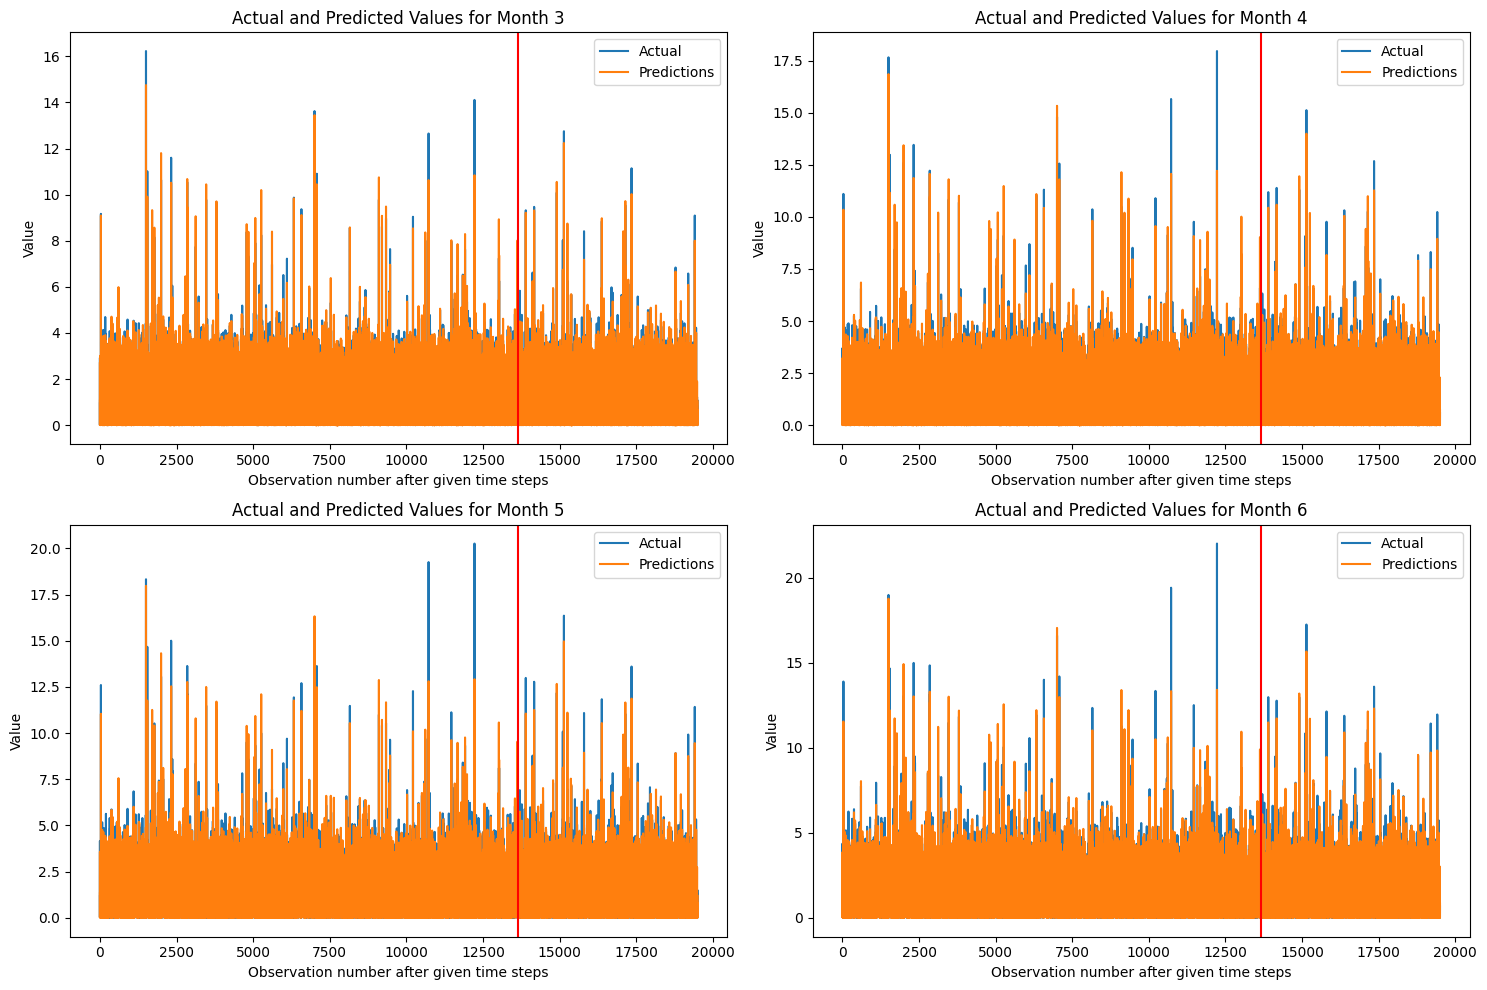

In [ ]:
# Plot differentiation graphs
train_predict = model.predict(x_train)

plot_result_multi(y_train, y_test, train_predict, DNNpredictions, y_test.columns)
plt.show()

## **2. Iterative Forecasting ARPU Values**

This approach uses the current best model to forecast the nearest timestamp of ARPU performance, for example forecast 'Week 2'. Then, add the 'Week 2' attribute to the IVs to forecast 'Week 3'.

*'Week 1' -> 'Week 2' & 'Month 3', 'Month 4', 'Month 5', 'Month 6' (original TVs)*

*'Week 1' 'Week 2' -> 'Week 3' & TVs*

*'Week 1' 'Week 2' 'Week 3' -> 'Week 4' & TVs*

The pattern keeps continue until the original target variables performance stop improving

**Pro:**

.no need to wait for weeks to get the complete records, the model only need the first week data to perform iterate forecasting

**Con:**

.long coding steps and model application is complicated

iteration 1

In [ ]:
# Change data type
data['ECPA'] = data['ECPA'].astype('float')
data['Keyword'] = data['Keyword'].astype('object')
data['Offer ID'] = data['Offer ID'].astype('object')
data['Affiliate ID'] = data['Affiliate ID'].astype('object')
data['Shortcode'] = data['Shortcode'].astype('object')

# Drop NA rows
filtered_empty = data.dropna(subset=['Offer ID', 'Affiliate ID', 'Shortcode', 'Total Sales', 'Day 1', 'Week 1'])

# Filter 0 values of the ARPU value
nonZero = filtered_empty [(filtered_empty ['Week 1'] > 0) & (filtered_empty ['Week 13'] > 0)
                         & (filtered_empty ['Week 1'] != filtered_empty ['Week 13'])].copy()

# Filter total sales
filtered_totalSales = nonZero [nonZero ['Total Sales'] >= 30].copy()

# Transform outliers
filtered_totalSales.loc[:,'Transform_TotalSales_log'] = np.log(filtered_totalSales['Total Sales'])
filtered_totalSales.loc[:,'Transform_ECPA'] = np.sqrt(filtered_totalSales['ECPA'])
filtered_totalSales.loc[:,'Transform_Day_1'] = np.sqrt(filtered_totalSales['Day 1'])
filtered_totalSales.loc[:,'Transform_Week_1'] = np.sqrt(filtered_totalSales['Week 1'])

# Transfrom date data type
filtered_totalSales['Date'] = pd.to_datetime(filtered_totalSales['Date'])

# Get current date time
current_date = datetime.now()

# Time slicing/filtering to get the completed records for machine learning
data_date = current_date - timedelta(days=93)
month3_data = filtered_totalSales[(filtered_totalSales['Date'] >= datetime(2022, 10, 1)) & (filtered_totalSales['Date'] <= data_date)]

# Define x and y
x = month3_data[['Country', 'Gateway','Telco', 'Shortcode', 'Keyword','Offer ID','Affiliate ID','Transform_TotalSales_log', 'Transform_ECPA', 'Transform_Day_1','Transform_Week_1']]
y = month3_data[['Week 2']]

# Target_encoder encode label to transform categorical variables to numerical forms
count_encoder = CountEncoder()
x.loc[:,'Country'] = count_encoder.fit_transform(x['Country'])
x.loc[:,'Gateway'] = count_encoder.fit_transform(x['Gateway'])
x.loc[:,'Telco'] = count_encoder.fit_transform(x['Telco'])
x.loc[:,'Shortcode'] = count_encoder.fit_transform(x['Shortcode'])
x.loc[:,'Keyword'] = count_encoder.fit_transform(x['Keyword'])
x.loc[:,'Offer ID'] = count_encoder.fit_transform(x['Offer ID'])
x.loc[:,'Affiliate ID'] = count_encoder.fit_transform(x['Affiliate ID'])

# Data splitting
try:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=41)
except:
    print("\nError: Not enough data for building a training model for Month 3")
    print("You may adjust the filter setting to include more data (Note: This will affect the prediction result)\n")
    exit()

# Normalization
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# DNN (loss = mae, output activation relu, remove l5)
model = Sequential()
model.add(Dense(300, input_dim=x_train.shape[1], activation='relu'))  # Input layer with 128 neurons and ReLU activation
model.add(Dense(200,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(100,activation='relu'))

# output layer (softmax = multinomial)
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')  # Using mean squared error as the loss function and Adam optimizer

# Early stoppage
early_stopping_monitor = EarlyStopping(patience=30)

history = model.fit(x_train, y_train, epochs=200, batch_size=30, validation_split=0.1, callbacks = [early_stopping_monitor])

Epoch 1/200
405/405 [==============================] - 4s 6ms/step - loss: 0.0425 - val_loss: 0.0287
Epoch 2/200
405/405 [==============================] - 3s 7ms/step - loss: 0.0301 - val_loss: 0.0278
Epoch 3/200
405/405 [==============================] - 3s 8ms/step - loss: 0.0280 - val_loss: 0.0286
Epoch 4/200
405/405 [==============================] - 2s 5ms/step - loss: 0.0279 - val_loss: 0.0254
Epoch 5/200
405/405 [==============================] - 2s 6ms/step - loss: 0.0259 - val_loss: 0.0313
Epoch 6/200
405/405 [==============================] - 2s 6ms/step - loss: 0.0248 - val_loss: 0.0255
Epoch 7/200
405/405 [==============================] - 2s 5ms/step - loss: 0.0250 - val_loss: 0.0272
Epoch 8/200
405/405 [==============================] - 3s 8ms/step - loss: 0.0242 - val_loss: 0.0266
Epoch 9/200
405/405 [==============================] - 3s 6ms/step - loss: 0.0236 - val_loss: 0.0251
Epoch 10/200
405/405 [==============================] - 2s 4ms/step - loss: 0.0245 - val_lo

In [ ]:
week2Pred = model.predict(x_test)
week2train = model.predict(x_train)
validFun(week2Pred, y_test, 0.3)

422/422 [==============================] - 1s 2ms/step
MAPE:  0.21138558982679206
RMSE:  0.051495969964966755
r2:  0.9844796258624777
Model Acceptance Percentage:  84.42906574394463


Add the predicted variables ('week2_pred') into IVs and predict 'Month 3,4,5,6'

In [ ]:
# rename column names
new_column_names = ['week2_pred']


# Rename the columns
week2_prediction_df = pd.DataFrame(week2Pred, columns=new_column_names)
week2_x_train_pred_df = pd.DataFrame(week2train, columns=new_column_names)



# Convert x_train and x_test to DataFrames
x_train_df = pd.DataFrame(x_train)
x_test_df = pd.DataFrame(x_test)

new_x_train2 = pd.concat([x_train_df, week2_x_train_pred_df], axis=1)
new_x_test2 = pd.concat([x_test_df, week2_prediction_df], axis=1)

new_column_names3 = ['Country', 'Gateway','Telco', 'Shortcode', 'Keyword','Offer ID','Affiliate ID',
                     'Transform_TotalSales_log', 'Transform_ECPA', 'Transform_Day_1','Transform_Week_1',
                     'week2_pred']

new_x_train2.columns = new_column_names3
new_x_test2.columns = new_column_names3

# Scale with robust scaler
new_x_train2 = scaler.fit_transform(new_x_train2)
new_x_test2 = scaler.transform(new_x_test2)

In [ ]:
y2 = month3_data[['Month 3', 'Month 4', 'Month 5', 'Month 6']]

dum1, dum2, y2_train, y2_test = train_test_split(x, y2, test_size=0.3, random_state=41)

In [ ]:
# DNN (loss = mae, output activation relu, remove l5)
L1 = 300
L2 = 200
L3 = 150
L4 = 100

model = Sequential()
model.add(Dense(L1, input_dim=new_x_train2.shape[1], activation='relu'))  # Input layer with 128 neurons and ReLU activation
model.add(Dense(L2,activation='relu'))
model.add(Dense(L3,activation='relu'))
model.add(Dense(L4,activation='relu'))

# output layer (softmax = multinomial)
model.add(Dense(4))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')  # Using mean squared error as the loss function and Adam optimizer

# Early stoppage
early_stopping_monitor = EarlyStopping(patience=30)

history = model.fit(new_x_train2, y2_train, epochs=200, batch_size=30, validation_split=0.1, callbacks = [early_stopping_monitor])

Epoch 1/200
405/405 [==============================] - 6s 9ms/step - loss: 0.2357 - val_loss: 0.2092
Epoch 2/200
405/405 [==============================] - 2s 5ms/step - loss: 0.2027 - val_loss: 0.2302
Epoch 3/200
405/405 [==============================] - 2s 5ms/step - loss: 0.1954 - val_loss: 0.1953
Epoch 4/200
405/405 [==============================] - 3s 7ms/step - loss: 0.1909 - val_loss: 0.2025
Epoch 5/200
405/405 [==============================] - 3s 7ms/step - loss: 0.1877 - val_loss: 0.1886
Epoch 6/200
405/405 [==============================] - 2s 5ms/step - loss: 0.1818 - val_loss: 0.1849
Epoch 7/200
405/405 [==============================] - 2s 5ms/step - loss: 0.1801 - val_loss: 0.2082
Epoch 8/200
405/405 [==============================] - 2s 5ms/step - loss: 0.1790 - val_loss: 0.1837
Epoch 9/200
405/405 [==============================] - 2s 5ms/step - loss: 0.1781 - val_loss: 0.1855
Epoch 10/200
405/405 [==============================] - 2s 6ms/step - loss: 0.1746 - val_lo

In [ ]:
week2_IV_Results = model.predict(new_x_test2)
week2_IV_Train = model.predict(new_x_train2)
validFun4TV(week2_IV_Results, y2_test, 0.3)

422/422 [==============================] - 2s 5ms/step
Metrics for Month 3:
MAPE: 0.3434228942016108
RMSE: 0.2679718139543805
R^2: 0.9357263373208312
Model Acceptance Percentage: 65.25951557093425


Metrics for Month 4:
MAPE: 0.36403084255371376
RMSE: 0.33831774321894487
R^2: 0.9205633547012313
Model Acceptance Percentage: 62.80276816608996


Metrics for Month 5:
MAPE: 0.3776554017901016
RMSE: 0.39524323734716454
R^2: 0.9076315735629339
Model Acceptance Percentage: 61.418685121107266


Metrics for Month 6:
MAPE: 0.39655499820385204
RMSE: 0.437481965924032
R^2: 0.8986611144311734
Model Acceptance Percentage: 59.844290657439444




**Results:**

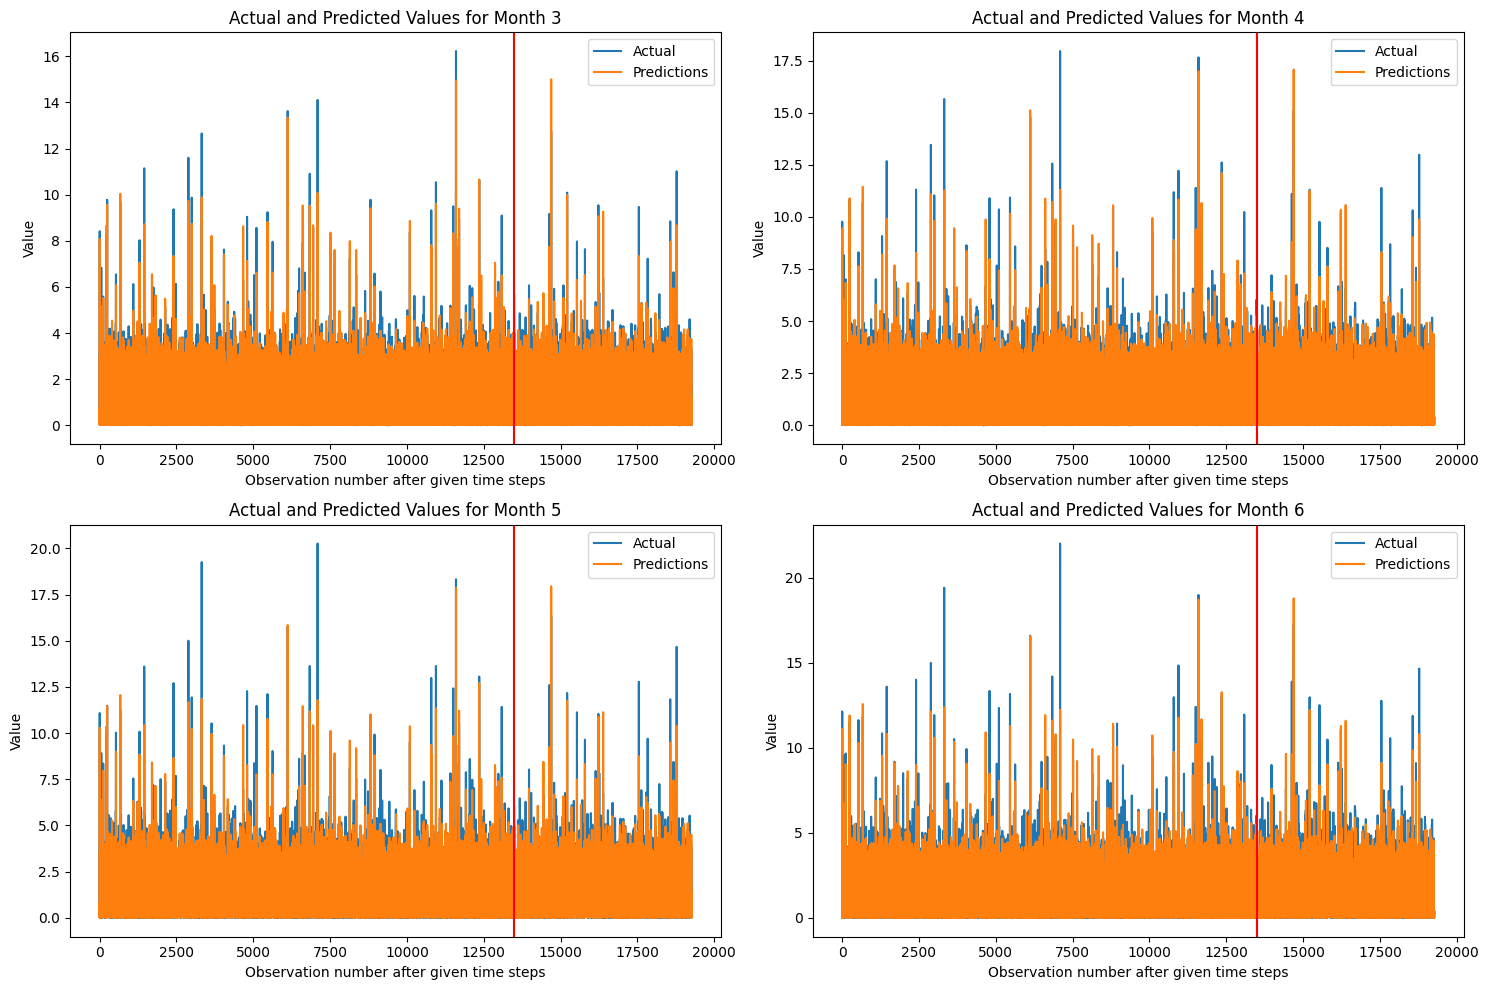

In [ ]:
# Plot differentiation graphs
plot_result_multi(y2_train, y2_test, week2_IV_Train, week2_IV_Results, y2_test.columns)
plt.show()

# **Create Dashboard & Deploy to Public Web**

Use dash plotly to create the dashboard & Render to delpoy the web.

The code is separate with this .ipynb file. The
source code in github: https://github.com/engkailun3117/fyp-web-dash/tree/main/src

the Render web deployment looks like this, it requires the user to connect to their git repository:

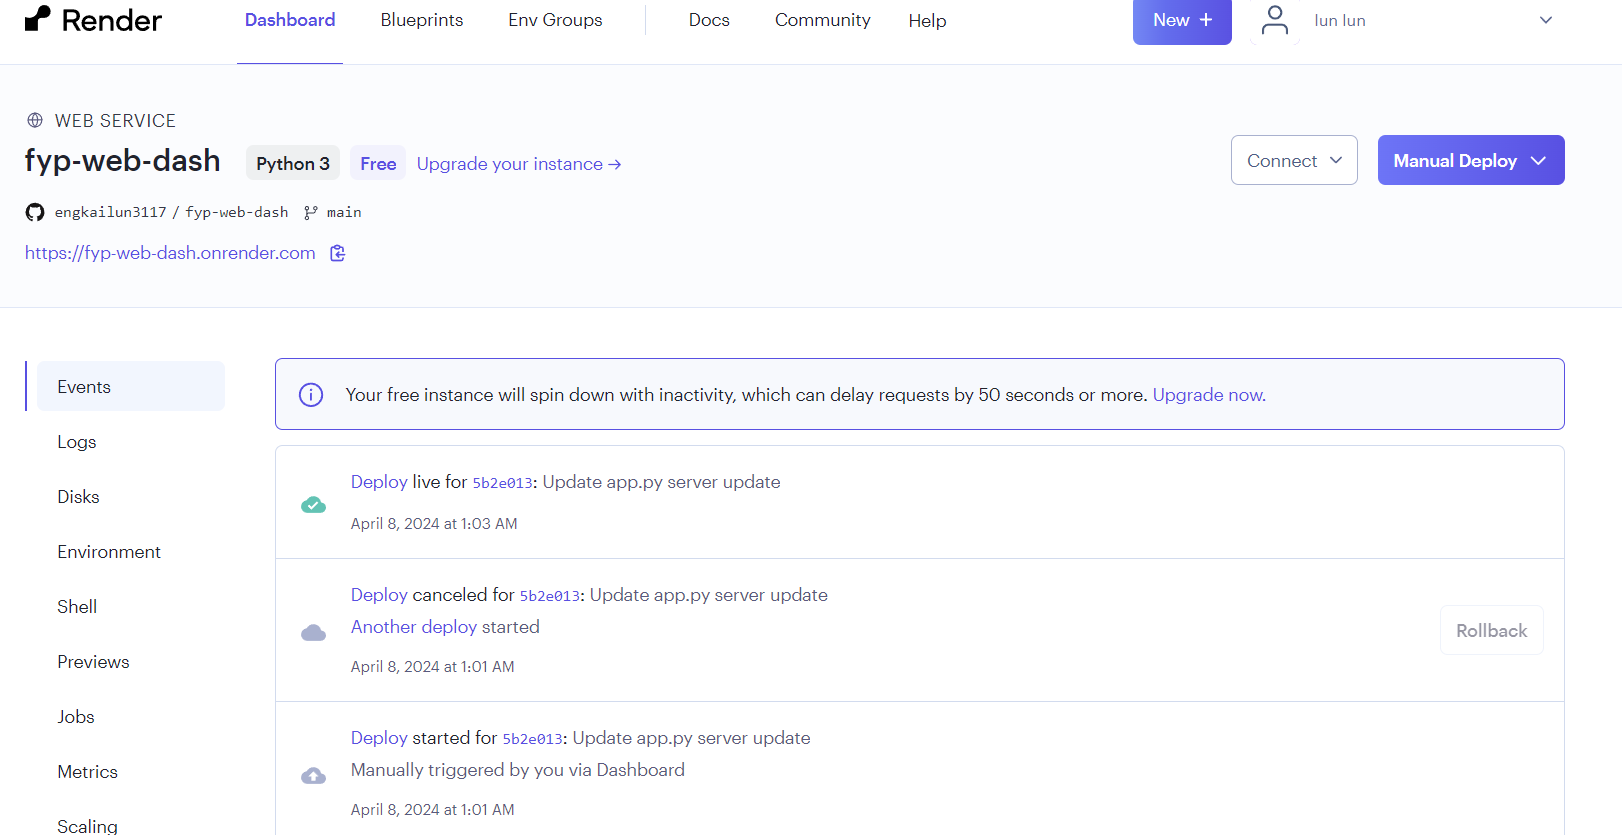

In [ ]:
from PIL import Image

img4 = Image.open('/drive/My Drive/Colab Notebooks/dash-render.png')
display(img4)

the dashboard web link: https://fyp-web-dash.onrender.com/

look like this:

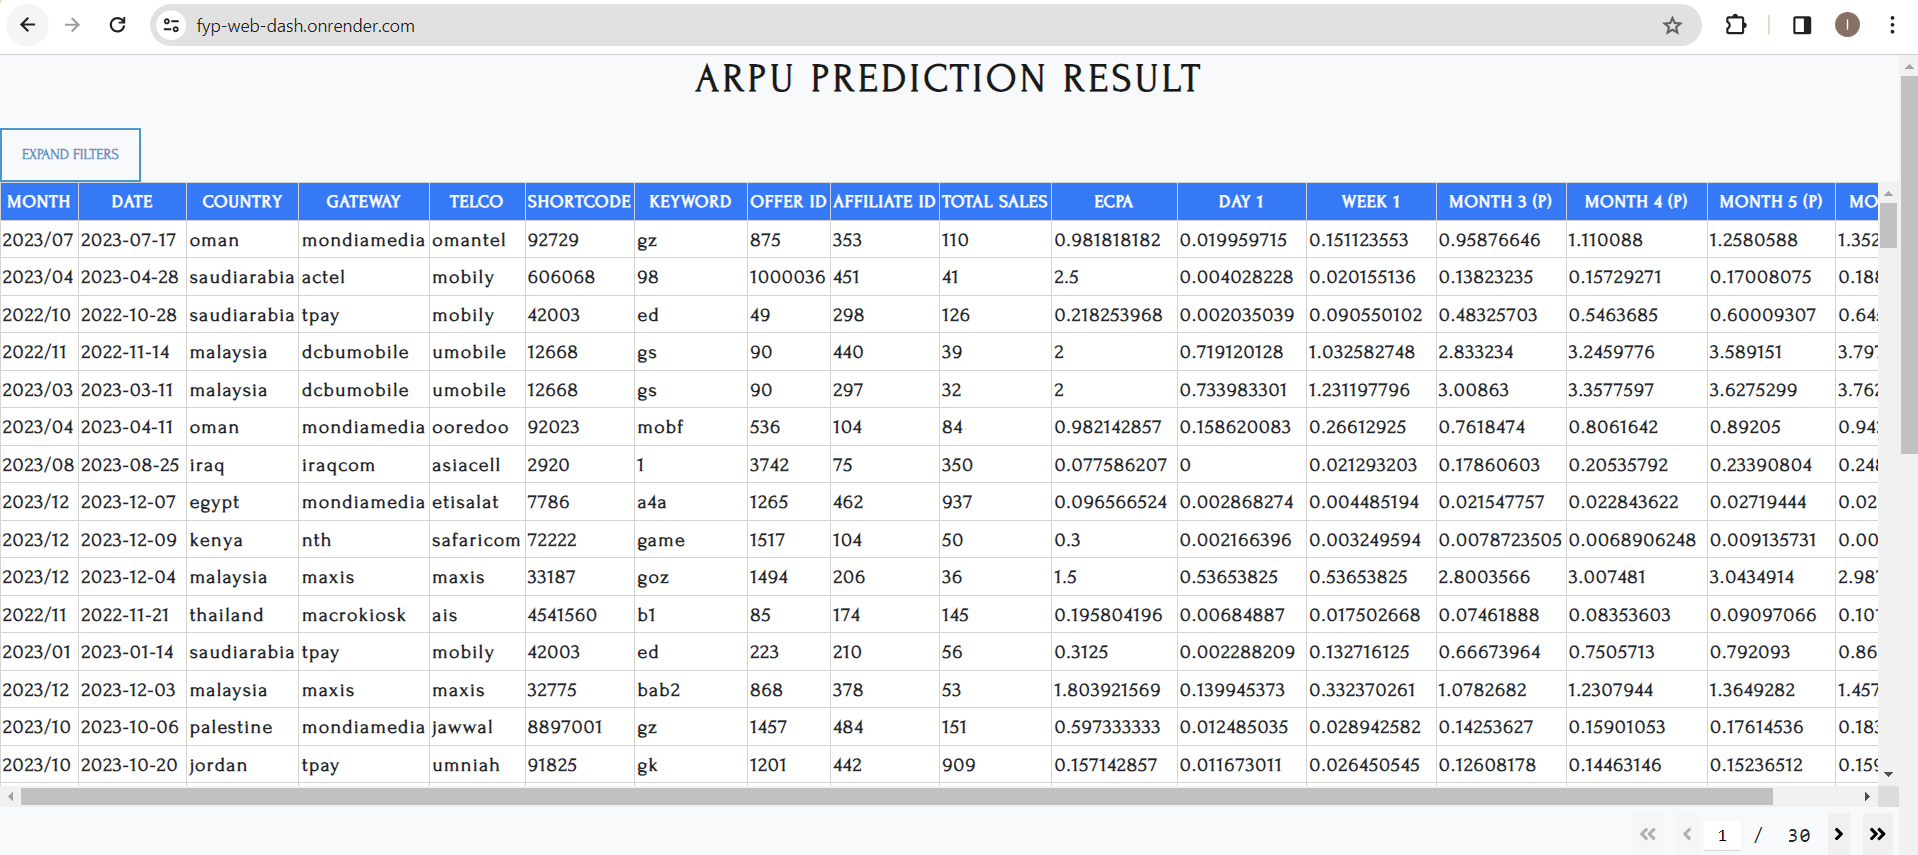

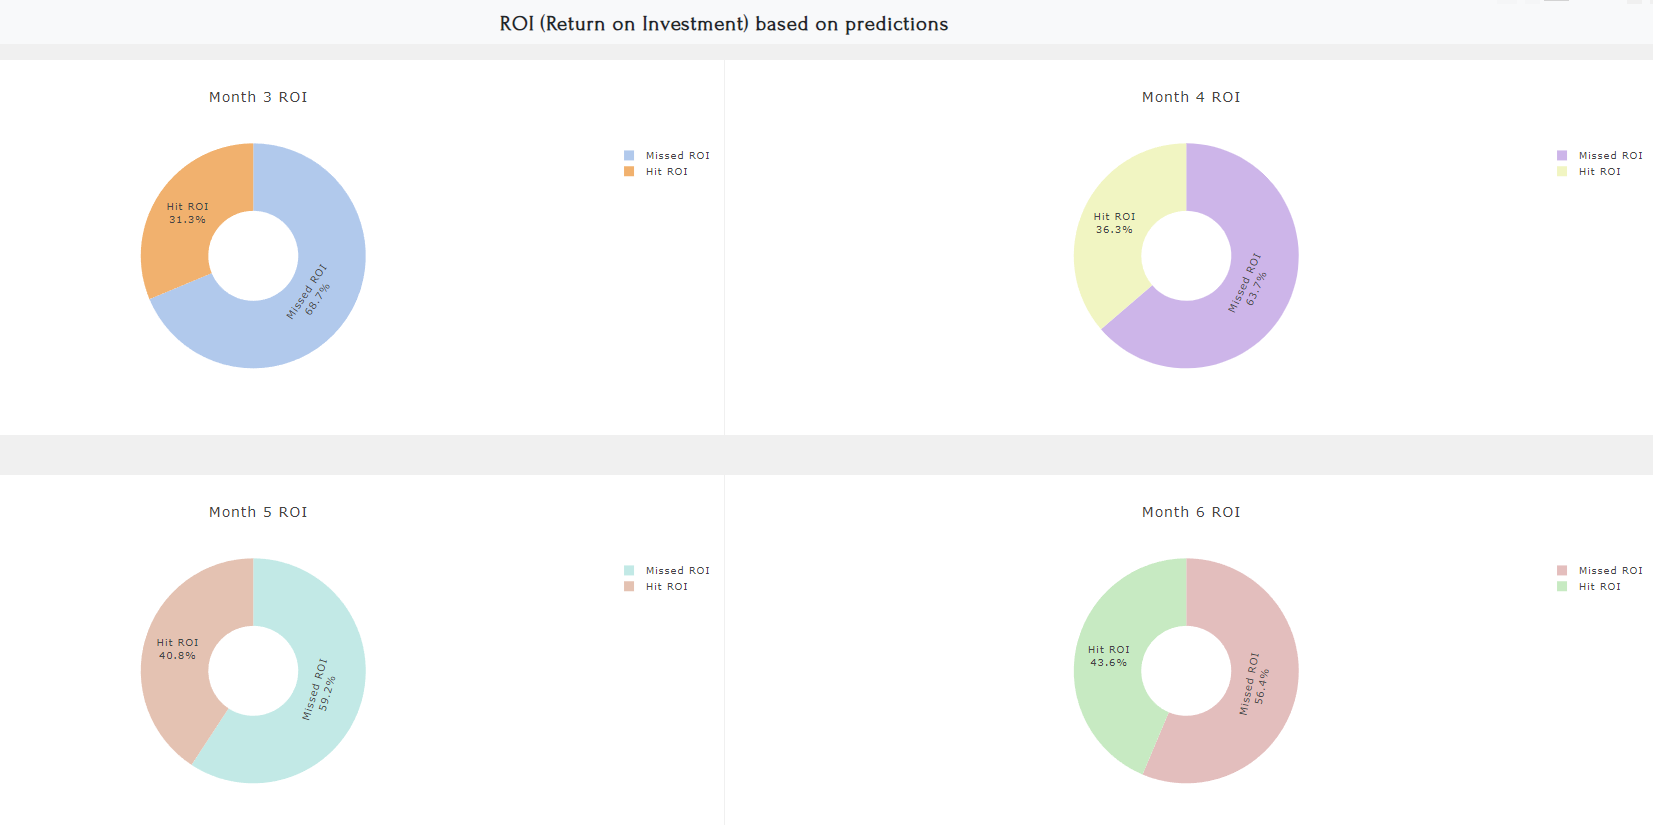

In [ ]:
img5 = Image.open('/drive/My Drive/Colab Notebooks/dashweb1.png')
display(img5)

img6 = Image.open('/drive/My Drive/Colab Notebooks/dashweb2.png')
display(img6)